# Ray Tracing from  base in Python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

width = 300
height = 200

## Defining the objects and light sources

In [7]:
# Define the objects present in the scene
objects = [
    {
        "center": np.array([-0.2, 0, -1]),
        "radius": 0.7,
        "ambient": np.array([0.1, 0, 0]),
        "diffuse": np.array([0.7, 0, 0]),
        "specular": np.array([1, 1, 1]),
        "shininess": 100,
    },
    {
        "center": np.array([0.1, -0.3, 0]),
        "radius": 0.1,
        "ambient": np.array([0.1, 0, 0.1]),
        "diffuse": np.array([0.7, 0, 0.7]),
        "specular": np.array([1, 1, 1]),
        "shininess": 100,
    },
    {
        "center": np.array([-0.3, 0, 0]),
        "radius": 0.15,
        "ambient": np.array([0, 0.1, 0]),
        "diffuse": np.array([0, 0.6, 0]),
        "specular": np.array([1, 1, 1]),
        "shininess": 100,
    },
]
# Define the light source
light = {
    "position": np.array([5, 5, 5]),
    "ambient": np.array([1, 1, 1]),
    "diffuse": np.array([1, 1, 1]),
    "specular": np.array([1, 1, 1]),
}

camera = np.array([0, 0, 1])
ratio = 1.0 * width / height
screen = (-1, 1.0 / ratio, 1, -1.0 / ratio)  # left, top, right, bottom

## Do the ray tracing

In [8]:
def get_sphere_intersect(sphere_center, sphere_radius, ray_origin, ray_direction):
    """
    Return the closest intersection point between the ray and the sphere
    """
    a = np.linalg.norm(ray_direction) ** 2  # if normalized, this is 1
    b = 2 * np.dot(ray_direction, ray_origin - sphere_center)
    c = np.linalg.norm(ray_origin - sphere_center) ** 2 - sphere_radius**2
    delta = b**2 - 4 * a * c

    if delta > 0:
        t1 = (-b - np.sqrt(delta)) / (2 * a)
        t2 = (-b + np.sqrt(delta)) / (2 * a)

        if t1 > 0 and t2 > 0:  # check if the intersection is in front of the camera
            return min(t1, t2)  # return the closest intersection point

    return None


def nearest_intersected_object(objects, ray_origin, ray_direction):
    """
    Return the nearest object and its intersection point with the ray
    """
    distances = [
        get_sphere_intersect(obj["center"], obj["radius"], ray_origin, ray_direction)
        for obj in objects
    ]
    nearest_object = None
    min_distance = np.inf

    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]

    return nearest_object, min_distance


def ray_tracing():
    image = np.zeros((height, width, 3))

    for i, y in tqdm(enumerate(np.linspace(screen[1], screen[3], height))):
        for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
            pixel = np.array([x, y, 0])
            direction = pixel - camera
            direction /= np.linalg.norm(direction)  # normalize

            # Find the nearest intersection
            nearest_object, min_distance = nearest_intersected_object(
                objects, camera, direction
            )

            if nearest_object is None:
                continue

            intersection = camera + min_distance * direction

            # find the normal to the intersection point
            normal_to_surface = intersection - nearest_object["center"]
            normal_to_surface /= np.linalg.norm(normal_to_surface)  # normalize

            # find the unit direction vector from the intersection point to the light source
            light_direction = light["position"] - intersection
            light_direction /= np.linalg.norm(light_direction)  # normalize

            _, min_distance = nearest_intersected_object(
                objects, intersection, light_direction
            )
            intersect_to_light_dist = np.linalg.norm(light["position"] - intersection)
            is_shadowed = min_distance < intersect_to_light_dist

            if is_shadowed:
                continue

            # RGB using Blenn-Phong model
            illumination = np.zeros((3))

            # add ambient
            illumination += nearest_object["ambient"] * light["ambient"]

            # add diffuse
            illumination += (
                nearest_object["diffuse"]
                * light["diffuse"]
                * np.dot(light_direction, normal_to_surface)
            )

            # add specular
            intersect_to_camera = camera - intersection
            intersect_to_camera /= np.linalg.norm(intersect_to_camera)  # normalize

            H = intersect_to_camera + light_direction
            H /= np.linalg.norm(H)  # normalize

            illumination += (
                nearest_object["specular"]
                * light["specular"]
                * np.dot(normal_to_surface, H) ** (nearest_object["shininess"] / 4)
            )

            # set the pixel color
            image[i, j] = np.clip(illumination, 0, 1)

    plt.imshow(image)
    plt.show()
    return image

200it [00:01, 142.28it/s]


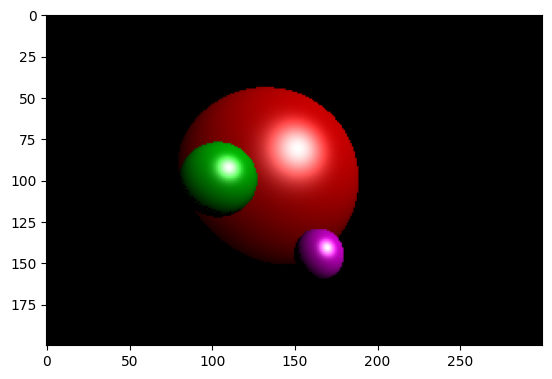

In [9]:
image = ray_tracing()

## Visualize the environment in 3D

In [ ]:
%pip install plotly nbformat

In [31]:
import plotly.graph_objects as go

fig = go.Figure()

# set the main camera at the camera_origin
fig.update_layout(scene_camera_eye=dict(x=camera[0], y=camera[1], z=camera[2]))

# Show the objects
for obj in objects:
    fig.add_trace(
        # Plot the sphere
        go.Scatter3d(
            x=[obj["center"][0]],
            y=[obj["center"][1]],
            z=[obj["center"][2]],
            mode="markers",
            marker=dict(color="lightpink", size=obj["radius"] * 50),
            name="sphere",
        )
    )

# Show the image screen as a plane with low opacity
fig.add_trace(
    go.Mesh3d(
        x=[screen[0], screen[0], screen[2], screen[2]],
        y=[screen[1], screen[3], screen[1], screen[3]],
        z=[0, 0, 0, 0],
        opacity=0.5,
        color="gray",
        name="image plane",
    )
)

# Show the light source as a yellow sphere
fig.add_trace(
    go.Scatter3d(
        x=[light["position"][0]],
        y=[light["position"][1]],
        z=[light["position"][2]],
        mode="markers",
        marker=dict(color="yellow", size=10),
        name="light source",
    )
)
fig.show()